# PRESELECCIÓN DE VARIABLES

## IMPORTAR PAQUETES

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer, recall_score
from sklearn.model_selection import cross_val_score

## IMPORTAR LOS DATOS

Ruta del proyecto.

In [38]:
ruta_proyecto = 'C:/Users/Alfonso/OneDrive/Documentos_/Formación/Bootcamp_DS/Repo_DS/Proyect_Break_ML/Proyecto_ML/00_PROYECTO_ML'

Nombres de los ficheros de datos.

In [39]:
nombre_df = 'df_tablon.pickle'

Cargar los datos.

In [40]:
df = pd.read_pickle(ruta_proyecto + '/02_Datos/03_Trabajo/' + nombre_df)

## MÉTODOS SUPERVISADOS

### Preparar x e y

In [41]:
target = 'response'
x = df.drop(columns = target).copy()
y =  df[target].copy()
print('X', x.shape)
print('y', y.shape)

X (1481, 35)
y (1481,)


### Mutual Information

#### Crear una función para mostrar el resultado

In [42]:
def ranking_mi(mutual_selector, modo = 'tabla'):
    #Maqueta el ranking
    ranking_mi = pd.DataFrame(mutual_selector, index = x.columns).reset_index()
    ranking_mi.columns = ['variable','importancia_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importancia_mi', ascending = False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    #Muestra la salida
    if modo == 'tabla':
        return(ranking_mi)
    else:
        g = ranking_mi.importancia_mi.sort_values().plot.barh(figsize = (12,20))
        g.set_yticklabels(ranking_mi.sort_values(by = 'importancia_mi').variable)
        return(g)

#### Calcular y revisar

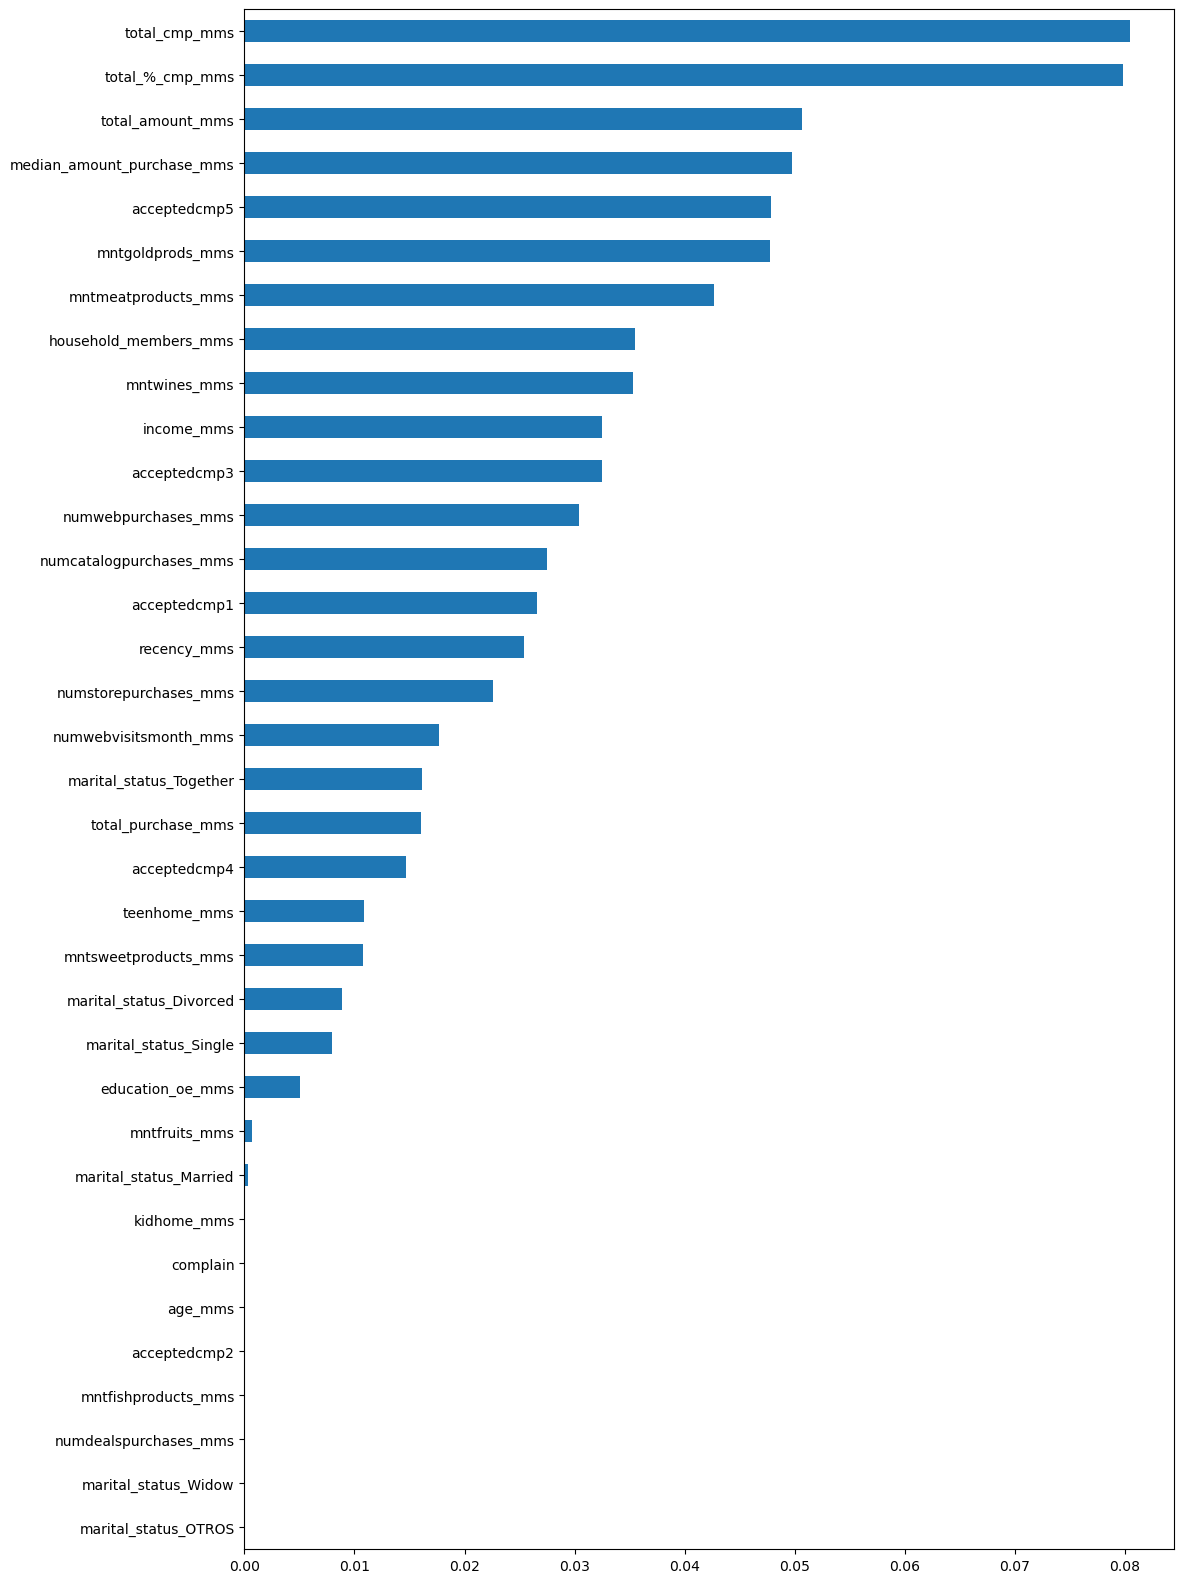

In [43]:
mutual_selector = mutual_info_classif(x,y, random_state=42) 

rank_mi = ranking_mi(mutual_selector, modo = 'grafico')

#### Seleccionar las variables que pasan

##### Definir la posición de la última variable que va a entrar

In [44]:
posicion_variable_limite = 23

##### Extraer los nombres de las que entran

In [45]:
entran_mi = ranking_mi(mutual_selector).iloc[0:posicion_variable_limite].variable

##### Crear el dataframe con la selección

In [46]:
x_mi = x[entran_mi].copy()

### Recursive Feature Elimination

#### Instanciar

In [47]:
rfe = RFE(estimator = XGBClassifier( n_jobs = -1, eval_metric='auc', random_state = 42)) 

#### Entrenar

In [48]:
rfe.fit(x,y)

RFE(estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                            colsample_bylevel=None, colsample_bynode=None,
                            colsample_bytree=None, device=None,
                            early_stopping_rounds=None,
                            enable_categorical=False, eval_metric='auc',
                            feature_types=None, gamma=None, grow_policy=None,
                            importance_type=None, interaction_constraints=None,
                            learning_rate=None, max_bin=None,
                            max_cat_threshold=None, max_cat_to_onehot=None,
                            max_delta_step=None, max_depth=None,
                            max_leaves=None, min_child_weight=None, missing=nan,
                            monotone_constraints=None, multi_strategy=None,
                            n_estimators=None, n_jobs=-1,
                            num_parallel_tree=None, random_state=42, ...))

##### Extraer los nombres de las que entran

In [49]:
entran_rfe = x.columns[rfe.support_]
entran_rfe

Index(['marital_status_Single', 'acceptedcmp1', 'education_oe_mms',
       'income_mms', 'recency_mms', 'mntwines_mms', 'mntmeatproducts_mms',
       'kidhome_mms', 'teenhome_mms', 'mntgoldprods_mms',
       'numdealspurchases_mms', 'numcatalogpurchases_mms',
       'numstorepurchases_mms', 'numwebvisitsmonth_mms',
       'household_members_mms', 'total_amount_mms', 'total_cmp_mms'],
      dtype='object')

#### Crear el dataframe con la selección

In [50]:
x_rfe = x[entran_rfe].copy()

### Permutation Importance

#### Crear una función para mostrar el resultado

In [51]:
def ranking_per(predictoras,permutacion):
    ranking_per = pd.DataFrame({'variable': predictoras.columns, 'importancia_per': permutacion.importances_mean}).sort_values(by = 'importancia_per', ascending = False)
    ranking_per['ranking_per'] = np.arange(0,ranking_per.shape[0])
    return(ranking_per)

#### Instanciar y entrenar

In [52]:
import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')

xgb = XGBClassifier(n_jobs = -1, eval_metric='auc', random_state = 42) 

xgb.fit(x,y)

scorer = make_scorer(recall_score, pos_label=1)

permutacion = permutation_importance(xgb, 
                                     x, y, 
                                     scoring = scorer,
                                     n_repeats=5,
                                     n_jobs = -1,
                                     random_state=42) 

#### Revisar la salida

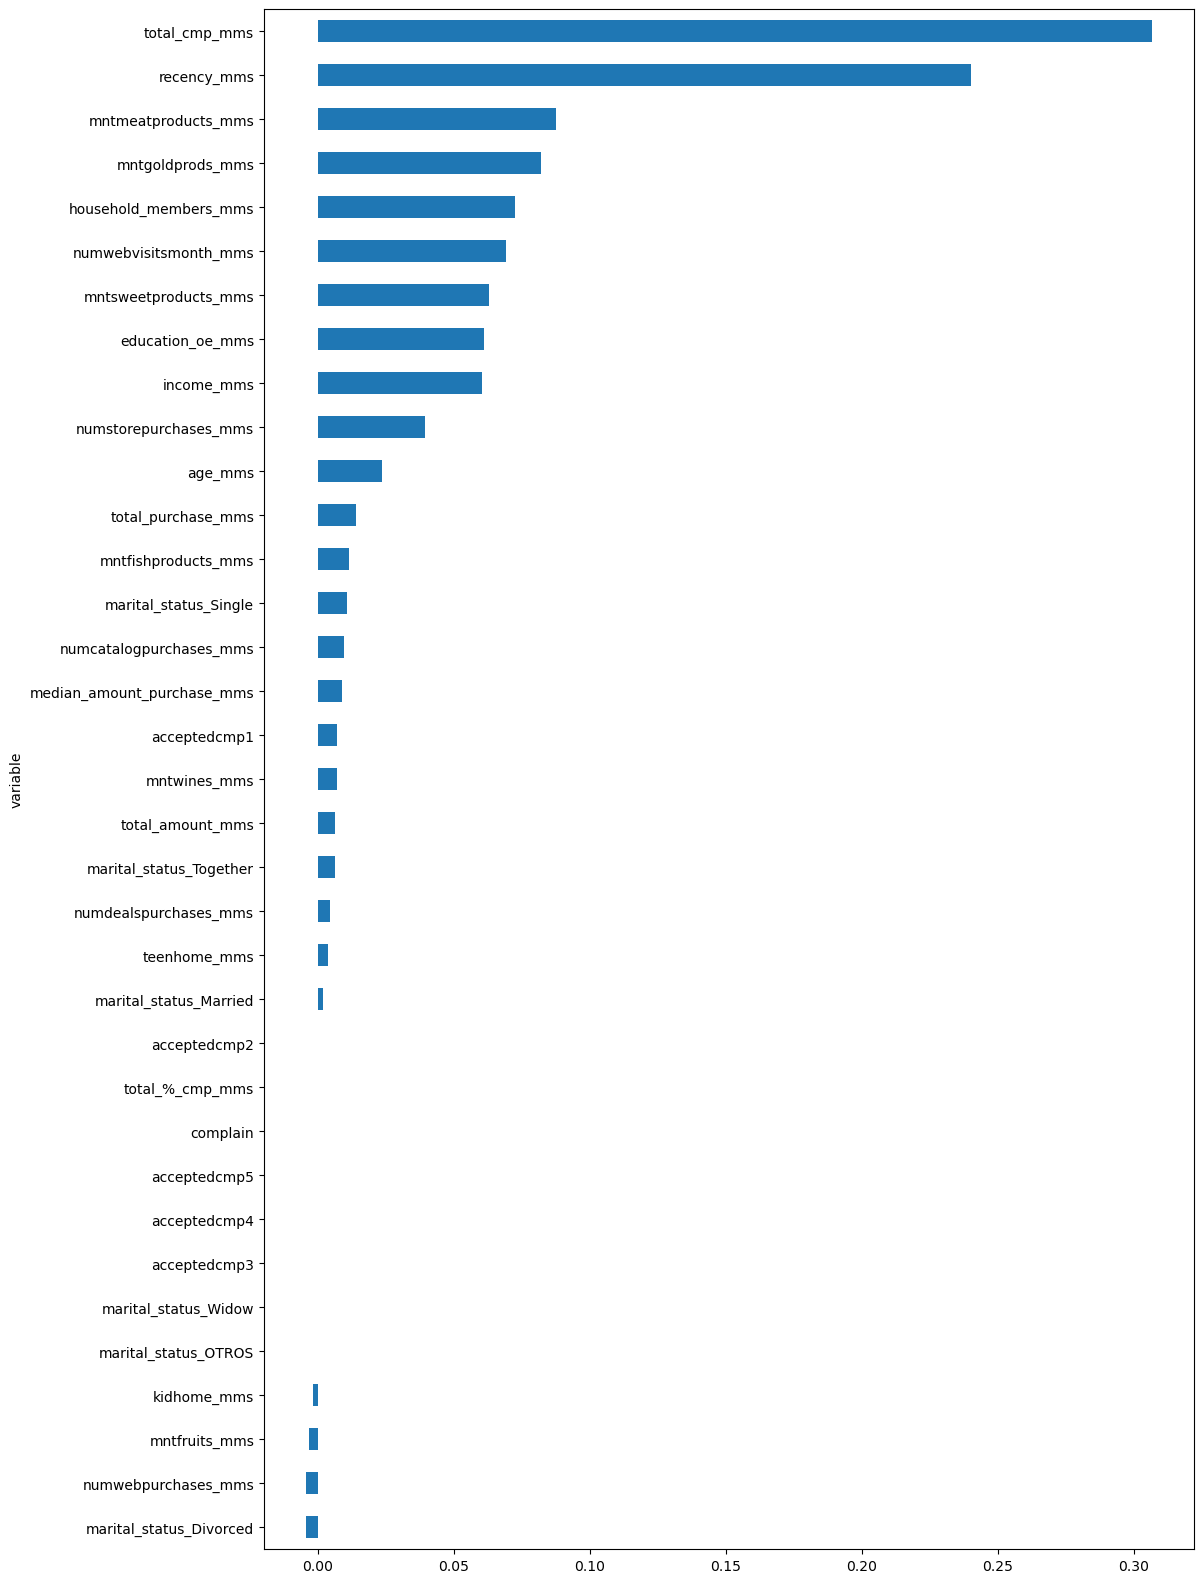

In [53]:
rank_per = ranking_per(x,permutacion)

rank_per.set_index('variable').importancia_per.sort_values().plot.barh(figsize = (12,20));

In [54]:
rank_per.set_index('variable').importancia_per.sort_values(ascending=False).head(10)

variable
total_cmp_mms            0.306550
recency_mms              0.240175
mntmeatproducts_mms      0.087336
mntgoldprods_mms         0.082096
household_members_mms    0.072489
numwebvisitsmonth_mms    0.068996
mntsweetproducts_mms     0.062882
education_oe_mms         0.061135
income_mms               0.060262
numstorepurchases_mms    0.039301
Name: importancia_per, dtype: float64

#### Seleccionar las variables que pasan

##### Definir la posición de la última variable que va a entrar

In [55]:
posicion_variable_limite = 20

##### Extraer los nombres de las que entran

In [56]:
entran_per = rank_per.iloc[0:posicion_variable_limite].variable

##### Crear el dataframe con la selección

In [57]:
x_per = x[entran_per].copy()

Resumen de los métodos empleados

In [60]:
x_preseleccionado_mi = x_mi
x_preseleccionado_rfe = x_rfe
x_preseleccionado_per = x_per

### Combinación por importancia

In [58]:
# Mutual Information
ranking_mi = pd.DataFrame(mutual_selector, index=x.columns).reset_index()
ranking_mi.columns = ['variable', 'importancia_mi']
ranking_mi = ranking_mi.sort_values(by='importancia_mi', ascending=False)
ranking_mi['ranking_mi'] = np.arange(0, ranking_mi.shape[0])

# RFE
ranking_rfe = pd.DataFrame(rfe.ranking_, index=x.columns).reset_index()
ranking_rfe.columns = ['variable', 'ranking_rfe']
ranking_rfe['importancia_rfe'] = 1 / ranking_rfe['ranking_rfe']

# Permutation Importance
ranking_pi = pd.DataFrame(permutacion.importances_mean, index=x.columns).reset_index()
ranking_pi.columns = ['variable', 'importancia_pi']
ranking_pi = ranking_pi.sort_values(by='importancia_pi', ascending=False)


# Normalizar las importancias
ranking_mi['importancia_mi'] /= ranking_mi['importancia_mi'].sum()
ranking_rfe['importancia_rfe'] /= ranking_rfe['importancia_rfe'].sum()
ranking_pi['importancia_pi'] /= ranking_pi['importancia_pi'].sum()


# Combinar las importancias
combined_importance = pd.merge(ranking_mi, ranking_rfe, on='variable')
combined_importance = pd.merge(combined_importance, ranking_pi, on='variable')
combined_importance['importancia_total'] = (combined_importance['importancia_mi'] + 
                                            combined_importance['importancia_rfe'] + 
                                            combined_importance['importancia_pi']) / 3

# Seleccionar las features con mayor importancia combinada
selected_features = combined_importance.sort_values(by='importancia_total', ascending=False).head(20).variable

print("Selected features:", selected_features)

Selected features: 0                  total_cmp_mms
14                   recency_mms
5               mntgoldprods_mms
6            mntmeatproducts_mms
7          household_members_mms
9                     income_mms
16         numwebvisitsmonth_mms
2               total_amount_mms
15         numstorepurchases_mms
24              education_oe_mms
1                total_%_cmp_mms
8                   mntwines_mms
3     median_amount_purchase_mms
12       numcatalogpurchases_mms
13                  acceptedcmp1
21          mntsweetproducts_mms
23         marital_status_Single
20                  teenhome_mms
4                   acceptedcmp5
28         numdealspurchases_mms
Name: variable, dtype: object


In [59]:
x_combinacion = selected_features.values[:12]
x_combinacion

array(['total_cmp_mms', 'recency_mms', 'mntgoldprods_mms',
       'mntmeatproducts_mms', 'household_members_mms', 'income_mms',
       'numwebvisitsmonth_mms', 'total_amount_mms',
       'numstorepurchases_mms', 'education_oe_mms', 'total_%_cmp_mms',
       'mntwines_mms'], dtype=object)

### Hard_Voting

In [61]:
lista_preseleccion = list([x_preseleccionado_per.columns, x_preseleccionado_mi.columns,x_preseleccionado_rfe.columns, x_combinacion])
conjunto_variables = set()
dicc_variables = {}
for lista in lista_preseleccion:
    for variable in lista:
        conjunto_variables.add(variable)
        if variable in dicc_variables:
            dicc_variables[variable] += 1
        else:
            dicc_variables[variable] = 1

hard_voting = pd.DataFrame.from_dict(dicc_variables, orient='index', columns=['count'])
hard_voting.sort_values(by='count', ascending=False)[:15]      

,count
total_cmp_mms,4
recency_mms,4
mntmeatproducts_mms,4
mntgoldprods_mms,4
household_members_mms,4
numwebvisitsmonth_mms,4
total_amount_mms,4
mntwines_mms,4
income_mms,4
numstorepurchases_mms,4


In [62]:
hard_voting_select = hard_voting.loc[hard_voting['count'] > 2].index
hard_voting_select


Index(['total_cmp_mms', 'recency_mms', 'mntmeatproducts_mms',
       'mntgoldprods_mms', 'household_members_mms', 'numwebvisitsmonth_mms',
       'education_oe_mms', 'income_mms', 'numstorepurchases_mms',
       'numcatalogpurchases_mms', 'acceptedcmp1', 'mntwines_mms',
       'total_amount_mms'],
      dtype='object')

### Variables tras EDA

In [63]:
# Estas variables fueron selecciondas tras el EDA e inspección visual
variables_select_visual = ['recency_mms',
  'mntwines_mms',
  'mntmeatproducts_mms',
  'numcatalogpurchases_mms',
  'acceptedcmp3',
  'acceptedcmp5',
  'acceptedcmp1']

## SELECCIONAR EL MÉTODO FINAL

Instanciar los modelos

In [64]:
ratio = (y == 0).sum()/(y != 0).sum()
log_reg = LogisticRegression(max_iter=5000,class_weight='balanced', random_state=42)
rl_select = RandomForestClassifier(max_depth=5, class_weight='balanced', random_state=42)
lgb_select = LGBMClassifier(max_depth = 5, is_unbalance = True, objective = 'binary', class_weight = 'balanced', random_state = 42, verbose = -1)
xgb_select = XGBClassifier(max_depth = 5,scale_pos_weight = ratio, random_state = 42)


Entrenar los modelos

In [65]:
lista_preseleccion = list([x_preseleccionado_per.columns, x_preseleccionado_mi.columns,x_preseleccionado_rfe.columns, hard_voting_select, x_combinacion, variables_select_visual])
metodos = (log_reg,rl_select, lgb_select, xgb_select)
nom_metodo = ('LogisticRegression','RandomForest', 'LGBoost', 'XGBoost')
nom_listas = ('PermutationImportance','MutualInformation','RFE','HardVoting', 'Combinacion', 'VisualSelection')
dicc_select = {}

recall_scorer = make_scorer(recall_score, pos_label=1)

for i,metodo in enumerate(metodos):
    for j,lista in enumerate(lista_preseleccion):
        scores = cross_val_score(metodo, x[lista], y, cv=5, scoring= recall_scorer)
        score = np.mean(scores)
        dicc_select[nom_metodo[i]] = score
        print(f'Para {nom_metodo[i]} con lista {nom_listas[j]}: {score:.3f}')
    print()


Para LogisticRegression con lista PermutationImportance: 0.764
Para LogisticRegression con lista MutualInformation: 0.764
Para LogisticRegression con lista RFE: 0.782
Para LogisticRegression con lista HardVoting: 0.777
Para LogisticRegression con lista Combinacion: 0.777
Para LogisticRegression con lista VisualSelection: 0.642

Para RandomForest con lista PermutationImportance: 0.637
Para RandomForest con lista MutualInformation: 0.625
Para RandomForest con lista RFE: 0.603
Para RandomForest con lista HardVoting: 0.664
Para RandomForest con lista Combinacion: 0.620
Para RandomForest con lista VisualSelection: 0.633

Para LGBoost con lista PermutationImportance: 0.742
Para LGBoost con lista MutualInformation: 0.764
Para LGBoost con lista RFE: 0.781
Para LGBoost con lista HardVoting: 0.782
Para LGBoost con lista Combinacion: 0.790
Para LGBoost con lista VisualSelection: 0.799

Para XGBoost con lista PermutationImportance: 0.515
Para XGBoost con lista MutualInformation: 0.568
Para XGBoost

## MÉTODOS NO SUPERVISADOS

### Correlación
Revisión de correlación entre variables seleccionadas

In [96]:
def correlaciones_fuertes(df, lim_inf = 0.30, lim_sup = 1,drop_dupli=True):
    #Calcula la matriz de correlación
    c = df.corr().abs()
    #Lo pasa todo a filas
    c= c.unstack()
    #Pasa el índice a columnas y le pone nombres
    c = pd.DataFrame(c).reset_index()
    c.columns = ['var1','var2','corr']
    #A dataframe, filtra limites y ordena en descendiente
    c = c.loc[(c['corr'] > lim_inf) &  (c['corr'] < lim_sup),:].sort_values(by = 'corr', ascending=False)
    #Desduplica las correlaciones (o no si drop_dupli es False)
    c = c if drop_dupli == False else c.drop_duplicates(subset = ['corr'])
    #Devuelve la salida
    return(c)

##### Calcular

In [97]:
cor_finales = correlaciones_fuertes(df[entran_rfe])

##### Revisar agregado

In [98]:
cor_finales.var1.value_counts()

var1
income_mms                 9
total_amount_mms           7
numcatalogpurchases_mms    6
mntwines_mms               5
numstorepurchases_mms      5
household_members_mms      5
kidhome_mms                4
numwebvisitsmonth_mms      4
mntgoldprods_mms           4
mntmeatproducts_mms        3
acceptedcmp1               2
teenhome_mms               2
total_cmp_mms              1
numdealspurchases_mms      1
Name: count, dtype: int64

In [99]:
cor_finales.var2.value_counts()

var2
mntmeatproducts_mms        8
mntwines_mms               6
numcatalogpurchases_mms    5
total_cmp_mms              5
numwebvisitsmonth_mms      5
household_members_mms      5
kidhome_mms                5
total_amount_mms           4
acceptedcmp1               4
numstorepurchases_mms      3
mntgoldprods_mms           3
income_mms                 2
numdealspurchases_mms      2
marital_status_Single      1
Name: count, dtype: int64

##### Revisar detalle

In [100]:
cor_finales.loc[(cor_finales['corr'] > 0.69)]

,var1,var2,corr
260,total_amount_mms,mntwines_mms,0.896465
261,total_amount_mms,mntmeatproducts_mms,0.853910
66,income_mms,total_amount_mms,0.804153
202,numcatalogpurchases_mms,total_amount_mms,0.803773
62,income_mms,numcatalogpurchases_mms,0.711817
113,mntmeatproducts_mms,numcatalogpurchases_mms,0.705374
57,income_mms,mntmeatproducts_mms,0.704261
56,income_mms,mntwines_mms,0.701848
33,acceptedcmp1,total_cmp_mms,0.700232


#### Filtrar variables

Lista variables a descartar por alta correlacion.

In [108]:
a_eliminar_corr = ['total_amount_mms','acceptedcmp1','kidhome_mms','teenhome_mms','numdealspurchases_mms']

* Las variables 'kidhome_mms','teenhome_mms','numdealspurchases_mms' se eliminan aquí pero no por correlación, sino por baja importancia para el modelo entrenado.

In [109]:
x_preseleccionado= x[cor_finales['var1'].unique()]
x_preseleccionado = x_preseleccionado.drop(columns=a_eliminar_corr)
x_preseleccionado

,income_mms,numcatalogpurchases_mms,mntmeatproducts_mms,mntwines_mms,numstorepurchases_mms,numwebvisitsmonth_mms,mntgoldprods_mms,household_members_mms,total_cmp_mms
ID,,,,,,,,,
1640,0.554626,0.090909,0.014538,0.046864,0.250000,0.181818,0.082645,0.50,0.00
977,0.386869,0.090909,0.113188,0.143475,0.583333,0.454545,0.078512,0.50,0.00
10150,0.766831,0.363636,0.904465,0.333814,0.500000,0.090909,0.152893,0.00,0.25
8181,0.302083,0.090909,0.048806,0.036049,0.166667,0.636364,0.099174,0.25,0.00
1399,0.635439,0.636364,0.460021,0.292718,0.666667,0.000000,0.838843,0.25,0.25
...,...,...,...,...,...,...,...,...,...
7999,0.658329,0.545455,0.426791,0.892574,0.333333,0.090909,0.070248,0.25,0.50
4548,0.334863,0.000000,0.008307,0.015862,0.166667,0.272727,0.061983,0.50,0.00
10785,0.355372,0.000000,0.008307,0.016583,0.166667,0.363636,0.016529,0.75,0.00


## GUARDAR DATASETS TRAS PRESELECCION DE VARIABLES

In [110]:
#Definir los nombres de los archivos
nombre_x_preseleccionado = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'x_preseleccionado.pickle'
nombre_y_preseleccionado = ruta_proyecto + '/02_Datos/03_Trabajo/' + 'y_preseleccionado.pickle'

In [111]:
#Guardar los archivos
x_preseleccionado.to_pickle(nombre_x_preseleccionado)

y_preseleccionado = y.copy()
y_preseleccionado.to_pickle(nombre_y_preseleccionado)

In [112]:
#Guardar los nombres de las variables finales
nombre_variables_finales = ruta_proyecto + '/05_Resultados/' + 'variables_finales.pickle'

x_preseleccionado.iloc[0].to_pickle(nombre_variables_finales)